## Autoencoders

**Autoencoders** are a type of neural network which learns a sparse representation of an input. In other words, an autoencoder, once trained on appropriate training data, can be used to generate compressed copies of an input data point which preserve most of the information (features) in the input using significantly fewer bits of information. 

Technically speaking, an autoencoder is any neural network with three components: an encoding function (which translates the data into a simpler space, e.g. a hidden layer with fewer nodes than on the input layer), a decoding function (which reverses this process, e.g. an output layer with equivalently many nodes as the input layer) and a distance metric (which measures loss as some distance between the original input and learned representation). The earliest type of autoencoders are [Restricted Boltzman Machines](https://www.kaggle.com/residentmario/restricted-boltzmann-machines-and-pretraining/notebook), which are important enough to the history of deep learning that they get their own name cred.

Autoencoders are the neural network equivalent of simpler variable compression techniques, like [PCA](https://www.kaggle.com/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist/) and [LDA](https://www.kaggle.com/residentmario/linear-discriminant-analysis-with-pokemon-stats). Autoencoders are practically used in deep learning applications for **pretraining**: determining the "right" weights for a neural network ahead of time, so that the algorithm doesn't have to work as hard to converge as it would if it had to start with completely random weights. For more on pretraining see [my notebook on RBMs](https://www.kaggle.com/residentmario/restricted-boltzmann-machines-and-pretraining/notebook). In practice, the emergence of [faster convergence algorithms](https://www.kaggle.com/residentmario/neural-network-activation-functions) has obviated the need and utility for pretraining.

Thus autoencoders are no longer used in cutting edge deep learning work. They're also not notably better than simpler (usually information-theoretic) compression algorithms, like JPEG and MG3, in commercial applications. These days they're most used as a preprocessing step on high-dimensionality data before input to T-SNE.

But they are nevertheless historically and pedologically important.

This notebook based on [this blog post](https://blog.keras.io/building-autoencoders-in-keras.html).

here is a first change.

## Demo
### Single-layer

The simplest possible autoencoder is a single hidden layer of $n < \text{# of input pixels}$ nodes. The output layer of this model mirrors the input layer in size. In the next few code cells we train just such a simple autoencoder and demonstrate its output.

In [5]:
import tensorflow
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)  # encoding_dim = 32
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# get the encoder and decoder as seperate models
# encoder
encoder = Model(input_img, encoded)

# decoder
encoded_input = Input(shape=(32,))  # encoding_dim = 32
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                validation_data=(x_test, x_test),
                verbose=1)

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.3806 - val_loss: 0.1907
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1805 - val_loss: 0.1542
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1496 - val_loss: 0.1342
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1320 - val_loss: 0.1225
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1214 - val_loss: 0.1141
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1136 - val_loss: 0.1084
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1079 - val_loss: 0.1037
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1037 - val_loss: 0.1003
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1010 - val_loss: 0.0979
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0987 - val_loss: 0.0961

KeyboardInterrupt: 

In [8]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

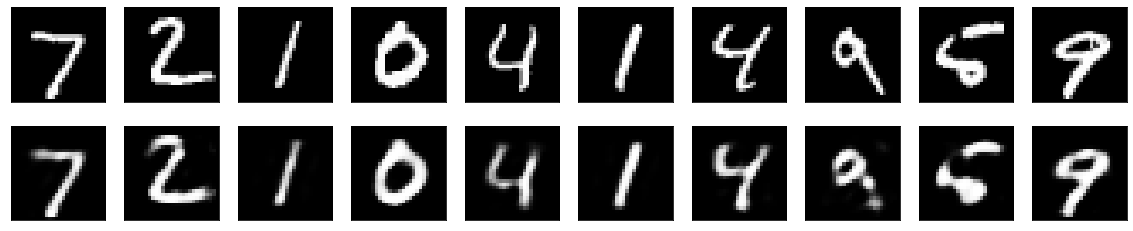

In [9]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We see here that the decoder trained in our autoencoder learns grainy (lossy) versions of the original images.

This form of simple one-layer autoencoder learns a representation of the underlying dataset that is very close to what is learned by PCA. You can thus think of this simple autoencoder as being a kind of stochastic approximation of the more deterministic PCA algorithm.

### Regularized single-layer

The idea is that an autoencoder ought to learn a spare representation of interesting features of the dataset, but when using standard convergence techniques more often than not it winds up learning how pixel maps moreso than interesting dataset features. One way to address this problem is to use regularization to introduce sparsity: make it so that only certain nodes fire on certain images, and the remainder stay silent. This way instead of learning "how to assemble fuzzy patches" into reconstructions of your inputs, the network will (hopefully) learn "how to assemble interesting _features_" into reconstructions of your input.

You can induce sparsity in your connections using [L1 regularization](https://www.kaggle.com/residentmario/l1-norms-versus-l2-norms). 

In [ ]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

### Deep

You can also use deeper autoencoders. These have all the benefits and tradeoffs you would expect of increasing the number of layers in your neural networks, namely: longer training times and less easily decoded representations, but more accurate reconstructions.

A good default choice for a deep autoencoder is to scale the image down progressively, than scale it back up again, using the same number of nodes on each layer on either side of the "most compressed" representation at the center of the hidden layers.

In [ ]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)